In [2]:
# %pip uninstall torch torchvision torchaudio transformers mamba-ssm tqdm pandas scikit-learn numpy -y
# %pip cache purge
# %pip install peft torch transformers mamba-ssm tqdm pandas scikit-learn numpy


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [4]:
splice_df = pd.read_csv('../data/Zea mayes/splice_sites_full_centered_balanced_correct-GCF_902167145-half_window-800.csv')
splice_df.head()

,id,coord,kind,transcript,strand,chrom,start,end,sequence,win_start,win_end,is_truncated,motif_len,motif
0,NC_050096.1_35318_donor,35318,0,XM_020544715.3,+,NC_050096.1,35319,35320,ATTAGCACAAAAAATAACAAAGTTCGGTTTAATTTGCCCAATTTGT...,34518,36120,False,2,GT
1,NC_050096.1_34607_acceptor,34607,1,XM_020544715.3,+,NC_050096.1,34605,34606,TTTTTTAGAACTCCAAAAACTGATGTAAAAAAGTCAAATAGCTCAG...,33804,35406,False,2,TG
2,NC_050096.1_36174_donor,36174,0,XM_020544715.3,+,NC_050096.1,36175,36176,TTTGTGTGCCCTACAAGGGAGTGCCAGTATTTATTTTCTTAATTGT...,35374,36976,False,2,GT
3,NC_050096.1_36037_acceptor,36037,1,XM_020544715.3,+,NC_050096.1,36035,36036,GAGAGCTTGGGAATGCGTCTCTCCTCGGCCAAACTCATCGCGCCTT...,35234,36836,False,2,AG
4,NC_050096.1_36504_donor,36504,0,XM_020544715.3,+,NC_050096.1,36505,36506,TGGCTTCTGTTGGCCTGGTTTAAGCCTTGCCTCTGTTCAGCTACAC...,35704,37306,False,2,GT


In [5]:
# Split data with stratification
train_df, temp_df = train_test_split(splice_df, test_size=0.3, stratify=splice_df['kind'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['kind'], random_state=42)

## Full Pipeline

In [6]:
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Train set size: 1425512
Validation set size: 305467


In [7]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4


In [8]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoConfig
from mamba_ssm import Mamba
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
import numpy as np

In [9]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [10]:
# Cell 2: Dataset Class (Modified)
class DNASequenceDataset(Dataset):
    def __init__(self, sequences, labels, max_length=1650):
        self.sequences = sequences
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.max_length = max_length
        self.nuc_to_idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4, 'P': 5}
        
        self.seq_encodings = []
        for seq in sequences:
            encoding = [self.nuc_to_idx.get(nuc, self.nuc_to_idx['N']) for nuc in seq[:max_length]]
            encoding += [self.nuc_to_idx['P']] * (max_length - len(encoding))
            self.seq_encodings.append(torch.tensor(encoding, dtype=torch.long))
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.seq_encodings[idx],
            'label': self.labels[idx]
        }

In [11]:
class MambaSequenceClassifier(nn.Module):
    def __init__(self, d_model=128, d_state=16, d_conv=4, expand=2, num_mamba_layers=4, n_classes=3, max_length=1650):
        super().__init__()
        self.nuc_embedding = nn.Embedding(6, d_model)  # ACGTNP to d_model
        self.pos_embedding = nn.Embedding(max_length, d_model)  # Learnable positional embeddings

        nn.init.xavier_uniform_(self.nuc_embedding.weight)
        nn.init.xavier_uniform_(self.pos_embedding.weight)
        
        self.mamba = nn.Sequential(*[
            nn.Sequential(
                nn.LayerNorm(d_model),
                Mamba(
                    d_model=d_model,
                    d_state=d_state,
                    d_conv=d_conv,
                    expand=expand,
                    use_fast_path=True
                ),
                nn.Dropout(0.1),
            ) for _ in range(num_mamba_layers)
        ])

        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(0.1),
            nn.Linear(d_model, n_classes)
        )
        
        # # simple scalar attention over time
        # self.attention_pool = nn.Sequential(
        #     nn.Linear(d_model, 1),
        #     nn.Softmax(dim=1)
        # )

        # Mini attention MLP
        self.attention_pool = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.Tanh(),
            nn.Linear(d_model // 2, 1),
            nn.Softmax(dim=1)
        )
            
    def forward(self, sequence, labels=None):
        pos_ids = torch.arange(sequence.size(1), device=sequence.device).unsqueeze(0).expand(sequence.size(0), -1)
        x = self.nuc_embedding(sequence) + self.pos_embedding(pos_ids)  # Add position to nucleotide embeddings
        x = self.mamba(x)
        weights = self.attention_pool(x)  # [B, T, 1]
        x = (x * weights).sum(dim=1)
        logits = self.classifier(x)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss(label_smoothing=0.1)(logits, labels)
            return loss, logits
        return None, logits


In [12]:
# Cell 4: Model Initialization (Modified)
def prepare_model_and_data(train_df, val_df, test_df, sample_size=5000, max_length=1650, use_full_data=False):
    if use_full_data:
        train_sample = train_df
        val_sample = val_df
        test_sample = test_df
    else:
        train_sample = train_df.groupby('kind', group_keys=False).apply(
            lambda x: x.sample(n=min(len(x), sample_size // 3))
        ).reset_index(drop=True)

        val_sample = val_df.groupby('kind', group_keys=False).apply(
            lambda x: x.sample(n=min(len(x), sample_size // 15))
        ).reset_index(drop=True)

        test_sample = test_df.groupby('kind', group_keys=False).apply(
            lambda x: x.sample(n=min(len(x), sample_size // 15))
        ).reset_index(drop=True)

    train_dataset = DNASequenceDataset(
        sequences=train_sample['sequence'].tolist(),
        labels=train_sample['kind'].tolist(),
        max_length=max_length
    )

    val_dataset = DNASequenceDataset(
        sequences=val_sample['sequence'].tolist(),
        labels=val_sample['kind'].tolist(),
        max_length=max_length
    )
    
    test_dataset = DNASequenceDataset(
        sequences=test_sample['sequence'].tolist(),
        labels=test_sample['kind'].tolist(),
        max_length=max_length
    )
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32)
    test_dataloader = DataLoader(test_dataset, batch_size=32)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MambaSequenceClassifier(
        d_model=128,
        d_state=16,
        d_conv=4,
        expand=1,
        num_mamba_layers=4,
        n_classes=3
    ).to(device)
    
    return model, train_dataloader, val_dataloader, test_dataloader, device



In [13]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the model and return comprehensive metrics.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            sequence = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            loss, logits = model(sequence, labels)
            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    
    # Calculate F1 scores for each class
    f1_scores = f1_score(all_labels, all_preds, average=None)
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate precision and recall
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    
    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'f1_scores': f1_scores,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall
    }
    
    return metrics

In [14]:
def train_model(model, train_dataloader, val_dataloader, test_dataloader, device, 
                num_epochs=10, patience=3, learning_rate=1e-4,
                checkpoint_dir='checkpoints'):
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Initialize optimizer and tracking variables
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Initialize tracking lists with F1 scores
    history = {
        'epoch': [], 'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [], 'learning_rate': [],
        'train_f1_class0': [], 'train_f1_class1': [],'train_f1_class2': [],
        'val_f1_class0': [], 'val_f1_class1': [], 'val_f1_class2': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []
        
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            sequence = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            loss, logits = model(sequence, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Calculate accuracy and store predictions
            predictions = torch.argmax(logits, dim=1)
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
            train_preds.extend(predictions.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = train_correct / train_total
        
        # Calculate F1 scores for training
        train_f1_scores = f1_score(train_labels, train_preds, average=None)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_dataloader:
                sequence = batch['sequence'].to(device)
                labels = batch['label'].to(device)
                
                loss, logits = model(sequence, labels)
                total_val_loss += loss.item()
                
                # Calculate accuracy and store predictions
                predictions = torch.argmax(logits, dim=1)
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
                val_preds.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = val_correct / val_total
        
        # Calculate F1 scores for validation
        val_f1_scores = f1_score(val_labels, val_preds, average=None)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history with F1 scores
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)
        history['learning_rate'].append(current_lr)
        history['train_f1_class0'].append(train_f1_scores[0])
        history['train_f1_class1'].append(train_f1_scores[1])
        history['train_f1_class2'].append(train_f1_scores[2])
        history['val_f1_class0'].append(val_f1_scores[0])
        history['val_f1_class1'].append(val_f1_scores[1])
        history['val_f1_class2'].append(val_f1_scores[2])
        
        # Print metrics
        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
        print(f'Train F1 (Class 0): {train_f1_scores[0]:.4f}, Train F1 (Class 1): {train_f1_scores[1]:.4f}, Train F1 (Class 2): {train_f1_scores[2]:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        print(f'Val F1 (Class 0): {val_f1_scores[0]:.4f}, Val F1 (Class 1): {val_f1_scores[1]:.4f}, Val F1 (Class 2): {val_f1_scores[2]:.4f}')
        print(f'Learning Rate: {current_lr}')
        
        # Save checkpoint for this epoch
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_acc': train_accuracy,
            'val_acc': val_accuracy,
            'train_f1_class0': train_f1_scores[0],
            'train_f1_class1': train_f1_scores[1],
            'train_f1_class2': train_f1_scores[2],
            'val_f1_class0': val_f1_scores[0],
            'val_f1_class1': val_f1_scores[1],
            'val_f1_class2': val_f1_scores[2],
            'learning_rate': current_lr
        }
        torch.save(checkpoint, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pt'))
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            
            # Save best model
            best_checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_acc': train_accuracy,
                'val_acc': val_accuracy,
                'train_f1_class0': train_f1_scores[0],
                'train_f1_class1': train_f1_scores[1],
                'train_f1_class2': train_f1_scores[2],
                'val_f1_class0': val_f1_scores[0],
                'val_f1_class1': val_f1_scores[1],
                'val_f1_class2': val_f1_scores[2],
                'learning_rate': current_lr
            }
            torch.save(best_checkpoint, os.path.join(checkpoint_dir, 'best_model.pt'))
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch + 1}')
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Final evaluation on test set
    print("\nPerforming final evaluation on test set...")
    test_metrics = evaluate_model(model, test_dataloader, device)
    
    print("\n=== Final Test Evaluation ===")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (Class 0): {test_metrics['f1_scores'][0]:.4f}")
    print(f"Test F1 (Class 1): {test_metrics['f1_scores'][1]:.4f}")
    print(f"Test F1 (Class 2): {test_metrics['f1_scores'][2]:.4f}")
    print("\nConfusion Matrix:")
    print(test_metrics['confusion_matrix'])
    print("\nPrecision (Class 0, Class 1, Class 2):", test_metrics['precision'])
    print("Recall (Class 0, Class 1, Class 2):", test_metrics['recall'])
    
    # Save final model with test metrics
    final_checkpoint = {
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'train_acc': train_accuracy,
        'val_acc': val_accuracy,
        'train_f1_class0': train_f1_scores[0],
        'train_f1_class1': train_f1_scores[1],
        'train_f1_class2': train_f1_scores[2],
        'val_f1_class0': val_f1_scores[0],
        'val_f1_class1': val_f1_scores[1],
        'val_f1_class2': val_f1_scores[2],
        'learning_rate': current_lr,
        'test_metrics': test_metrics
    }
    torch.save(final_checkpoint, os.path.join(checkpoint_dir, 'final_model.pt'))
    
    # Convert history to DataFrame
    history_df = pd.DataFrame(history)
    return history_df, test_metrics

In [15]:
# Cell 6: Run the Pipeline
# Initialize model and data
model, train_dataloader, val_dataloader, test_dataloader, device = prepare_model_and_data(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    use_full_data=False,
    sample_size=2000
)

# Train the model
history_df, test_metrics = train_model(
    model, 
    train_dataloader, 
    val_dataloader, 
    test_dataloader, 
    device, 
    num_epochs=20, 
    patience=3, 
    learning_rate=1e-4,
    checkpoint_dir='model_checkpoints_half_window_800'
)

Epoch 1/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/20:
Train Loss: 1.0459, Train Acc: 0.4434
Train F1 (Class 0): 0.3428, Train F1 (Class 1): 0.3921, Train F1 (Class 2): 0.5701
Val Loss: 1.0118, Val Acc: 0.4762
Val F1 (Class 0): 0.0000, Val F1 (Class 1): 0.5503, Val F1 (Class 2): 0.6147
Learning Rate: 0.0001


Epoch 2/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/20:
Train Loss: 0.9634, Train Acc: 0.5070
Train F1 (Class 0): 0.4099, Train F1 (Class 1): 0.3959, Train F1 (Class 2): 0.6917
Val Loss: 0.8992, Val Acc: 0.5514
Val F1 (Class 0): 0.0147, Val F1 (Class 1): 0.5922, Val F1 (Class 2): 0.7760
Learning Rate: 0.0001


Epoch 3/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/20:
Train Loss: 0.9228, Train Acc: 0.5445
Train F1 (Class 0): 0.4174, Train F1 (Class 1): 0.4541, Train F1 (Class 2): 0.7415
Val Loss: 1.1294, Val Acc: 0.4461
Val F1 (Class 0): 0.0000, Val F1 (Class 1): 0.5473, Val F1 (Class 2): 0.5028
Learning Rate: 0.0001


Epoch 4/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/20:
Train Loss: 0.8954, Train Acc: 0.5606
Train F1 (Class 0): 0.4341, Train F1 (Class 1): 0.4710, Train F1 (Class 2): 0.7617
Val Loss: 0.8412, Val Acc: 0.5865
Val F1 (Class 0): 0.3116, Val F1 (Class 1): 0.5799, Val F1 (Class 2): 0.8046
Learning Rate: 0.0001


Epoch 5/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/20:
Train Loss: 0.8451, Train Acc: 0.5921
Train F1 (Class 0): 0.4707, Train F1 (Class 1): 0.4859, Train F1 (Class 2): 0.8055
Val Loss: 0.8672, Val Acc: 0.5564
Val F1 (Class 0): 0.5906, Val F1 (Class 1): 0.1333, Val F1 (Class 2): 0.8000
Learning Rate: 0.0001


Epoch 6/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/20:
Train Loss: 0.8517, Train Acc: 0.5966
Train F1 (Class 0): 0.4693, Train F1 (Class 1): 0.4967, Train F1 (Class 2): 0.8077
Val Loss: 0.8039, Val Acc: 0.6040
Val F1 (Class 0): 0.0704, Val F1 (Class 1): 0.6455, Val F1 (Class 2): 0.8201
Learning Rate: 0.0001


Epoch 7/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/20:
Train Loss: 0.8548, Train Acc: 0.5971
Train F1 (Class 0): 0.4653, Train F1 (Class 1): 0.5038, Train F1 (Class 2): 0.7989
Val Loss: 0.8117, Val Acc: 0.5940
Val F1 (Class 0): 0.0000, Val F1 (Class 1): 0.6313, Val F1 (Class 2): 0.8327
Learning Rate: 0.0001


Epoch 8/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/20:
Train Loss: 0.8051, Train Acc: 0.6266
Train F1 (Class 0): 0.5081, Train F1 (Class 1): 0.5087, Train F1 (Class 2): 0.8497
Val Loss: 0.8106, Val Acc: 0.6065
Val F1 (Class 0): 0.0571, Val F1 (Class 1): 0.6321, Val F1 (Class 2): 0.8696
Learning Rate: 0.0001


Epoch 9/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/20:
Train Loss: 0.7896, Train Acc: 0.6411
Train F1 (Class 0): 0.5158, Train F1 (Class 1): 0.5407, Train F1 (Class 2): 0.8538
Val Loss: 0.7971, Val Acc: 0.6015
Val F1 (Class 0): 0.5106, Val F1 (Class 1): 0.4644, Val F1 (Class 2): 0.8514
Learning Rate: 0.0001


Epoch 10/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/20:
Train Loss: 0.7648, Train Acc: 0.6602
Train F1 (Class 0): 0.5662, Train F1 (Class 1): 0.5207, Train F1 (Class 2): 0.8758
Val Loss: 0.9535, Val Acc: 0.5464
Val F1 (Class 0): 0.0429, Val F1 (Class 1): 0.6032, Val F1 (Class 2): 0.7558
Learning Rate: 0.0001


Epoch 11/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/20:
Train Loss: 0.7373, Train Acc: 0.6937
Train F1 (Class 0): 0.6068, Train F1 (Class 1): 0.5689, Train F1 (Class 2): 0.8959
Val Loss: 0.7960, Val Acc: 0.5789
Val F1 (Class 0): 0.5539, Val F1 (Class 1): 0.1951, Val F1 (Class 2): 0.8247
Learning Rate: 0.0001


Epoch 12/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/20:
Train Loss: 0.7255, Train Acc: 0.7142
Train F1 (Class 0): 0.6121, Train F1 (Class 1): 0.6169, Train F1 (Class 2): 0.9068
Val Loss: 0.8074, Val Acc: 0.5739
Val F1 (Class 0): 0.5955, Val F1 (Class 1): 0.0567, Val F1 (Class 2): 0.8268
Learning Rate: 0.0001


Epoch 13/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/20:
Train Loss: 0.6828, Train Acc: 0.7643
Train F1 (Class 0): 0.6811, Train F1 (Class 1): 0.6789, Train F1 (Class 2): 0.9290
Val Loss: 0.7890, Val Acc: 0.6291
Val F1 (Class 0): 0.5886, Val F1 (Class 1): 0.4615, Val F1 (Class 2): 0.8171
Learning Rate: 0.0001


Epoch 14/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/20:
Train Loss: 0.6500, Train Acc: 0.8013
Train F1 (Class 0): 0.7271, Train F1 (Class 1): 0.7263, Train F1 (Class 2): 0.9486
Val Loss: 0.8221, Val Acc: 0.6692
Val F1 (Class 0): 0.4976, Val F1 (Class 1): 0.6569, Val F1 (Class 2): 0.7900
Learning Rate: 0.0001


Epoch 15/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/20:
Train Loss: 0.6042, Train Acc: 0.8283
Train F1 (Class 0): 0.7435, Train F1 (Class 1): 0.7791, Train F1 (Class 2): 0.9585
Val Loss: 0.7807, Val Acc: 0.6692
Val F1 (Class 0): 0.4815, Val F1 (Class 1): 0.6582, Val F1 (Class 2): 0.8346
Learning Rate: 0.0001


Epoch 16/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/20:
Train Loss: 0.5698, Train Acc: 0.8483
Train F1 (Class 0): 0.7748, Train F1 (Class 1): 0.7959, Train F1 (Class 2): 0.9731
Val Loss: 0.8472, Val Acc: 0.6817
Val F1 (Class 0): 0.6593, Val F1 (Class 1): 0.5659, Val F1 (Class 2): 0.8190
Learning Rate: 0.0001


Epoch 17/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/20:
Train Loss: 0.5174, Train Acc: 0.8954
Train F1 (Class 0): 0.8519, Train F1 (Class 1): 0.8648, Train F1 (Class 2): 0.9687
Val Loss: 0.7553, Val Acc: 0.6967
Val F1 (Class 0): 0.6607, Val F1 (Class 1): 0.5455, Val F1 (Class 2): 0.8561
Learning Rate: 0.0001


Epoch 18/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/20:
Train Loss: 0.4660, Train Acc: 0.9239
Train F1 (Class 0): 0.8964, Train F1 (Class 1): 0.9023, Train F1 (Class 2): 0.9724
Val Loss: 0.7844, Val Acc: 0.7494
Val F1 (Class 0): 0.7108, Val F1 (Class 1): 0.7420, Val F1 (Class 2): 0.8070
Learning Rate: 0.0001


Epoch 19/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/20:
Train Loss: 0.4281, Train Acc: 0.9505
Train F1 (Class 0): 0.9319, Train F1 (Class 1): 0.9328, Train F1 (Class 2): 0.9865
Val Loss: 0.6935, Val Acc: 0.7895
Val F1 (Class 0): 0.7605, Val F1 (Class 1): 0.7615, Val F1 (Class 2): 0.8436
Learning Rate: 0.0001


Epoch 20/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/20:
Train Loss: 0.4046, Train Acc: 0.9590
Train F1 (Class 0): 0.9425, Train F1 (Class 1): 0.9493, Train F1 (Class 2): 0.9850
Val Loss: 0.6768, Val Acc: 0.8020
Val F1 (Class 0): 0.8030, Val F1 (Class 1): 0.7875, Val F1 (Class 2): 0.8178
Learning Rate: 0.0001

Performing final evaluation on test set...

=== Final Test Evaluation ===
Test Loss: 0.7072
Test Accuracy: 0.8020
Test F1 (Class 0): 0.7969
Test F1 (Class 1): 0.7820
Test F1 (Class 2): 0.8306

Confusion Matrix:
[[104  24   5]
 [ 13 113   7]
 [ 11  19 103]]

Precision (Class 0, Class 1, Class 2): [0.8125     0.72435897 0.89565217]
Recall (Class 0, Class 1, Class 2): [0.78195489 0.84962406 0.77443609]


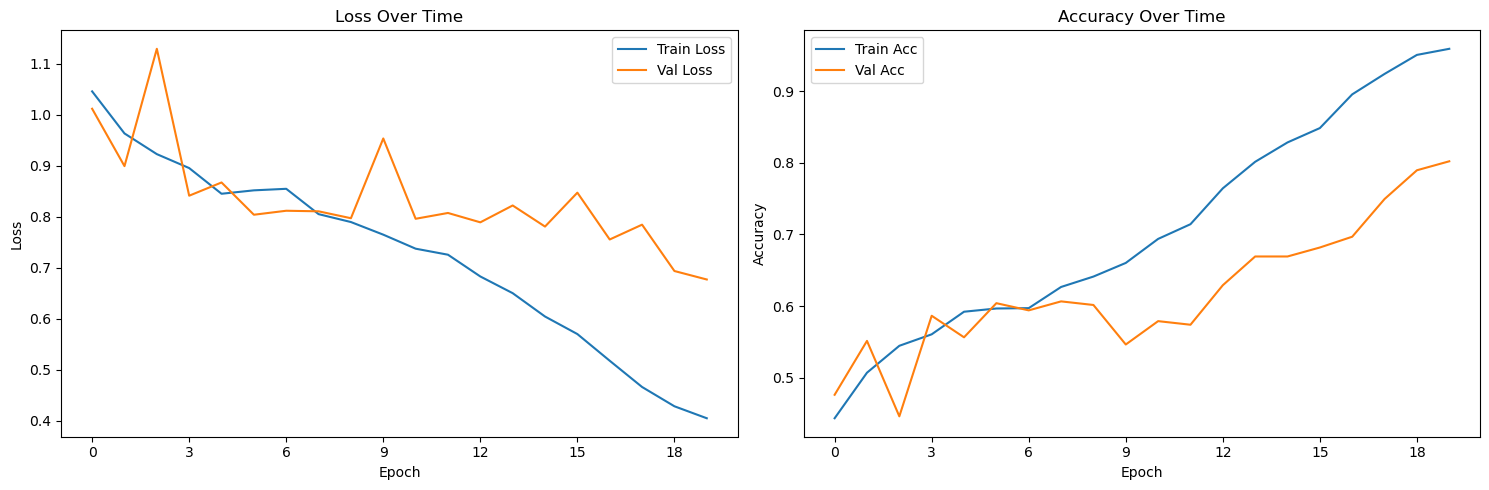

In [16]:
# Plot training history
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['train_loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.subplot(1, 2, 2)
plt.plot(history_df['train_acc'], label='Train Acc')
plt.plot(history_df['val_acc'], label='Val Acc')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [17]:
def load_best_model_and_evaluate(model, checkpoint_path, test_dataloader, device):
    """
    Load the best model checkpoint and evaluate it on the test set.
    
    Args:
        model: The model architecture
        checkpoint_path: Path to the best model checkpoint
        test_dataloader: DataLoader for the test set
        device: Device to run the model on (cuda or cpu)
    
    Returns:
        test_metrics: Dictionary containing test metrics
    """
    # Load the checkpoint
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    # Print checkpoint information
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"Validation loss: {checkpoint['val_loss']:.4f}")
    print(f"Validation accuracy: {checkpoint['val_acc']:.4f}")
    print(f"Validation F1 (Class 0): {checkpoint['val_f1_class0']:.4f}")
    print(f"Validation F1 (Class 1): {checkpoint['val_f1_class1']:.4f}")
    print(f"Validation F1 (Class 2): {checkpoint['val_f1_class2']:.4f}")
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_metrics = evaluate_model(model, test_dataloader, device)
    
    # Print test metrics
    print("\n=== Test Evaluation Results ===")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (Class 0): {test_metrics['f1_scores'][0]:.4f}")
    print(f"Test F1 (Class 1): {test_metrics['f1_scores'][1]:.4f}")
    print(f"Test F1 (Class 2): {test_metrics['f1_scores'][2]:.4f}")
    print("\nConfusion Matrix:")
    print(test_metrics['confusion_matrix'])
    print("\nPrecision (Class 0, Class 1, Class 2):", test_metrics['precision'])
    print("Recall (Class 0, Class 1, Class 2):", test_metrics['recall'])
    
    return test_metrics

# Example usage:
# checkpoint_path = 'model_checkpoints/best_model.pt'
# test_metrics = load_best_model_and_evaluate(model, checkpoint_path, test_dataloader, device)

In [21]:
# After training, load the best model and evaluate
# checkpoint_path = 'model_checkpoints_half_window_800/best_model.pt'
#test_metrics = load_best_model_and_evaluate(model, checkpoint_path, test_dataloader, device)

Loading checkpoint from model_checkpoints_half_window_800/best_model.pt...


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

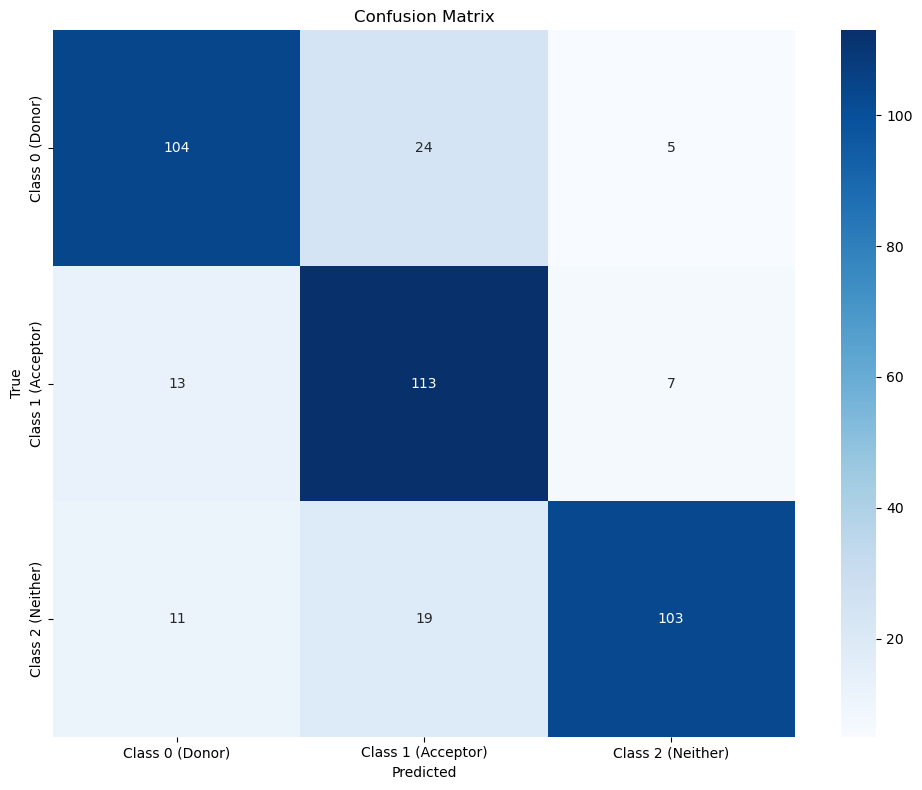

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, class_names=None):
    """
    Plot confusion matrix as a heatmap.
    
    Args:
        confusion_matrix: 2D numpy array of confusion matrix
        class_names: List of class names (optional)
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(test_metrics['confusion_matrix'], 
                     class_names=['Class 0 (Donor)', 'Class 1 (Acceptor)', 'Class 2 (Neither)'])


=== Sorghum Test Evaluation ===
Loss: 0.8844
Accuracy: 0.7419
F1 (Donor): 0.7693
F1 (Acceptor): 0.7794
F1 (Neither): 0.6484

Confusion Matrix:
[[1352  267   47]
 [ 112 1516   38]
 [ 385  441  840]]

Precision: [0.73120606 0.68165468 0.90810811]
Recall: [0.81152461 0.90996399 0.50420168]


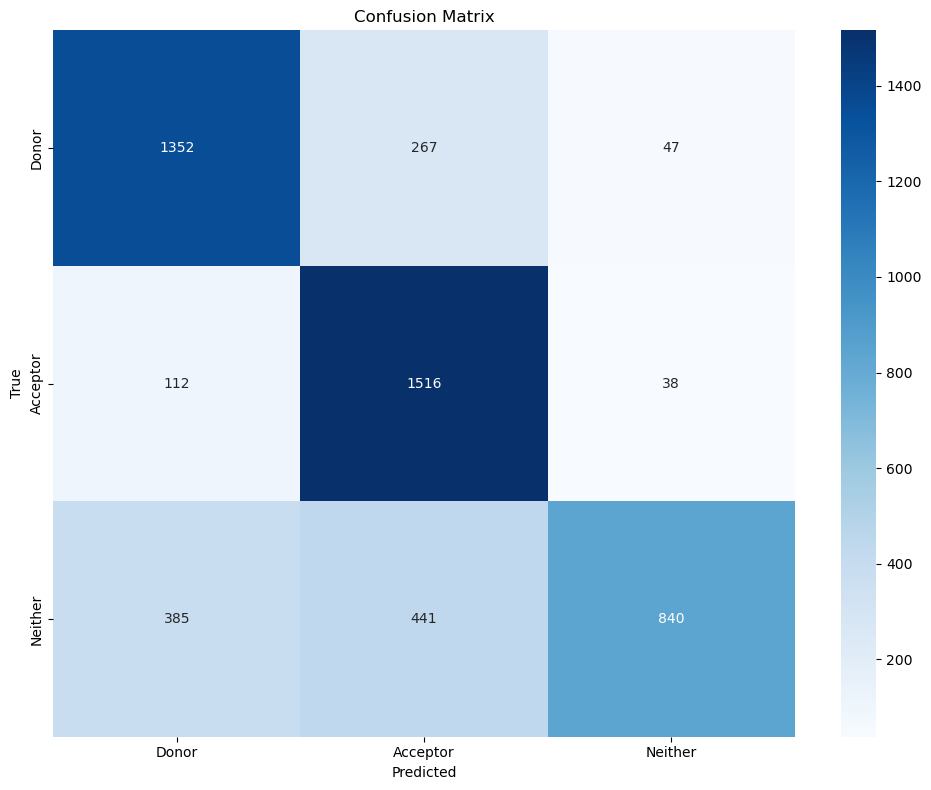

In [ ]:
# Load Sorghum dataset
sorghum_df = pd.read_csv(
    '../data/Sorghum/splice_sites_full_centered_balanced_correct-GCF_000003195-half_window-800.csv'
)

# Optional: subsample for faster evaluation (adjust or remove as needed)
#sorghum_test_sample = sorghum_df.groupby('kind', group_keys=False).apply(
#    lambda x: x.sample(n=min(len(x), 5000 // 3), random_state=42)
#).reset_index(drop=True)

# Create dataset and dataloader
sorghum_dataset = DNASequenceDataset(
    sequences=sorghum_df['sequence'].tolist(),
    labels=sorghum_df['kind'].tolist(),
    max_length=1650
)
sorghum_dataloader = DataLoader(sorghum_dataset, batch_size=32)

# Evaluate
sorghum_metrics = evaluate_model(model, sorghum_dataloader, device)

# Print metrics
print("\n=== Sorghum Test Evaluation ===")
print(f"Loss: {sorghum_metrics['loss']:.4f}")
print(f"Accuracy: {sorghum_metrics['accuracy']:.4f}")
print(f"F1 (Donor): {sorghum_metrics['f1_scores'][0]:.4f}")
print(f"F1 (Acceptor): {sorghum_metrics['f1_scores'][1]:.4f}")
print(f"F1 (Neither): {sorghum_metrics['f1_scores'][2]:.4f}")
print("\nConfusion Matrix:")
print(sorghum_metrics['confusion_matrix'])
print("\nPrecision:", sorghum_metrics['precision'])
print("Recall:", sorghum_metrics['recall'])

# Optional: plot confusion matrix
plot_confusion_matrix(sorghum_metrics['confusion_matrix'], 
                      class_names=['Donor', 'Acceptor', 'Neither'])